In [4]:
from feed_utils import *

/Users/ravi.tej/anaconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ravi.tej/anaconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ravi.tej/anaconda3/envs/venv/lib/python3.11/site-packages/uma

In [5]:
with open("ect_bge_small_search.dill", "rb") as f:
    ect_bge_small = dill.load(f)

In [6]:
bge_hierarchy = deepcopy(ect_bge_small.hierarchical_topics)
bge_topic_hierarchy = TopicHierarchy(bge_hierarchy, ect_bge_small.bertopic_model.topics_)
bge_levels = bge_topic_hierarchy.get_levels()
num_points, points = bge_topic_hierarchy.get_raw_leaf_points()

# Updating DataFrame as before
bge_hierarchy['Level'] = bge_hierarchy['Parent_ID'].map(bge_levels)
bge_hierarchy['num_points'] = bge_hierarchy['Parent_ID'].map(num_points)
bge_hierarchy['points'] = bge_hierarchy['Parent_ID'].map(points)

In [7]:
root_index = bge_hierarchy['num_points'].argmax()
root_parent_id = bge_hierarchy.iloc[root_index]['Parent_ID']

In [9]:
root_parent_id

'1934'

In [8]:
balanced_clusters = get_balanced_clusters(bge_hierarchy,parent_id = root_parent_id, max_points = 5000)
len(balanced_clusters)

34

In [9]:
balanced_clusters_df = bge_hierarchy[bge_hierarchy.Parent_ID.isin(balanced_clusters)]

In [10]:
assigned_clusters = assign_outliers_to_balanced_clusters(balanced_clusters_df=balanced_clusters_df,
                                                        document_topic=ect_bge_small.bertopic_model.topics_,
                                                        probabilities=ect_bge_small.bertopic_model.probabilities_)

In [11]:
assigned_clusters

,original_index,new_cluster,total_probability
0,0,1920,0.012067
1,1,1879,0.168825
2,2,1899,0.120623
3,3,1920,0.428434
4,4,1927,0.071728
...,...,...,...
67929,67929,1899,1.000000
67930,67930,1800,0.069228
67931,67931,1800,0.011845
67932,67932,1844,0.084591


In [12]:
tmp = assigned_clusters.groupby('new_cluster')['original_index'].apply(list)
cluster_to_documents = {cluster: tmp[cluster] for cluster in tmp.keys()}

In [13]:
candidate_keywords = ['mutual funds', 'indian economy', 'global economy', 'oil & gas', 'gold', 
                      'automobile sector', 'AI', 'retirement goals', 'taxation', 'credit health', 
                     'tech and startups', 'precious metals & commodities', 'government benefits',
                     'forex & currency', 'IPOs, M&As', 'markets', 'investment basics', 'personal finance',
                     'real estate guide', 'insurance']

In [14]:
len(candidate_keywords)

20

In [15]:
# select random choice of interests between 3-10

In [16]:
probs = [np.log10(i) for i in range(3,11)]

In [17]:
def simulate_num_preferences():
    rand_value = np.random.rand()
    valid_idx = [idx for idx, val in enumerate(probs) if val >= rand_value]
    return min(valid_idx) + 3

In [18]:
simulate_num_preferences()

3

In [19]:
def simulate_topic_preferences(num_pref):
    return np.random.choice(candidate_keywords, size=num_pref, replace = False)

In [20]:
topics = simulate_topic_preferences(4)

In [21]:
topics

array(['indian economy', 'government benefits', 'automobile sector',
       'mutual funds'], dtype='<U29')

In [22]:
topic_cluster_map = {}
for _, row in bge_hierarchy[bge_hierarchy.Parent_ID.isin(balanced_clusters)].iterrows():
    for topic in row['Topics']:
        topic_cluster_map[topic] = row['Parent_ID']

In [23]:
from collections import defaultdict

In [27]:
def get_modified_similarity_score(score, idx):
    position_scaling = (np.log10(idx + 2)/np.log10(5))
    return ((score - 0.7)/(1 - 0.7))*min(1, 1/position_scaling)

In [28]:
%timeit get_modified_similarity_score(0.756, 10)

1.01 µs ± 3.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [29]:
def get_cluster_scores_for_word(word):
    similar_topics, similarity = ect_bge_small.bertopic_model.find_topics(word,top_n=10)
    modified_similarity = [get_modified_similarity_score(original_score, idx) for idx, original_score in enumerate(similarity)]
    similar_clusters = [topic_cluster_map[topic] if topic != -1 else -1 for topic in similar_topics]
    result = defaultdict(float)  # Initialize a defaultdict with default value as float (0.0)
    for cluster, sim in zip(similar_clusters, modified_similarity):
        result[cluster] += sim
    return result

In [53]:
def update_cluster_priors_for_keyword(word, cluster_priors):
    cluster_scores = get_cluster_scores_for_word(word)
    for cluster in cluster_scores.keys():
        if cluster == -1:
            continue
        else:
            cluster_priors[cluster]['a'] = np.round(min(5, cluster_scores[cluster] + cluster_priors[cluster]['a']),2)
    return cluster_priors

In [939]:
ect_bge_small.bertopic_model?

Type:           BERTopic
String form:    BERTopic(calculate_probabilities=True, ctfidf_model=ClassTfidfTransformer(...), embedding_model=< <...> None, top_n_words=10, umap_model=UMAP(...), vectorizer_model=CountVectorizer(...), verbose=False)
File:           ~/anaconda3/envs/venv/lib/python3.11/site-packages/bertopic/_bertopic.py
Docstring:     
BERTopic is a topic modeling technique that leverages BERT embeddings and
c-TF-IDF to create dense clusters allowing for easily interpretable topics
whilst keeping important words in the topic descriptions.

The default embedding model is `all-MiniLM-L6-v2` when selecting `language="english"`
and `paraphrase-multilingual-MiniLM-L12-v2` when selecting `language="multilingual"`.

Attributes:
    topics_ (List[int]) : The topics that are generated for each document after training or updating
                          the topic model. The most recent topics are tracked.
    probabilities_ (List[float]): The probability of the assigned topic per doc

In [31]:
def simulate_cluster_preferences(topics):
    cluster_priors = {cluster: {'a': 1, 'b': 2} for cluster in balanced_clusters}
    for topic in topics:
        cluster_priors = update_cluster_priors_for_keyword(topic, cluster_priors=cluster_priors)
    return cluster_priors

In [76]:
# from collections import defaultdict

# def combine_cluster_scores(cluster_score_dicts):
#     combined_scores = defaultdict(float)  # Initialize a defaultdict with default value as float (0.0)
    
#     for cluster_scores in cluster_score_dicts:
#         for cluster, score in cluster_scores.items():
#             combined_scores[cluster] = combined_scores.get(cluster, {'a': 1, 'b': 2})
#             combined_scores[cluster]['a'] = min(5, combined_scores[cluster]['a'] + score['a'] - 1)
            
#     return combined_scores

In [74]:
# from concurrent.futures import ThreadPoolExecutor
# from functools import partial


# def update_cluster_priors_parallel(topic):
#     global cluster_priors  # Ensure the function can access the global variable, or pass it explicitly
#     return update_cluster_priors_for_keyword(topic, cluster_priors=cluster_priors)

In [75]:
# def parallize_stuff():
#     cluster_priors = {cluster: {'a': 1, 'b': 2} for cluster in balanced_clusters}

#     # with ThreadPoolExecutor() as executor:
#     #     results = list(executor.map(update_cluster_priors_parallel, topics))
#     with ThreadPoolExecutor() as executor:
#         # f = partial(update_cluster_priors_for_keyword, cluster_priors=cluster_priors)
#         # results = list(executor.map(f, topics))
#         results = list(executor.map(update_cluster_priors_parallel, topics))

#     # Combine results if needed
#     updated_scores = combine_cluster_scores(results)

In [77]:
simulate_cluster_preferences(topics)

{'1927': {'a': 1, 'b': 2},
 '1862': {'a': 1, 'b': 2},
 '1781': {'a': 1, 'b': 2},
 '1891': {'a': 1, 'b': 2},
 '1826': {'a': 1, 'b': 2},
 '1873': {'a': 1, 'b': 2},
 '1870': {'a': 2.56, 'b': 2},
 '1732': {'a': 1, 'b': 2},
 '1904': {'a': 1.41, 'b': 2},
 '1414': {'a': 1, 'b': 2},
 '1815': {'a': 1, 'b': 2},
 '1905': {'a': 4.77, 'b': 2},
 '1902': {'a': 1, 'b': 2},
 '1882': {'a': 1.6, 'b': 2},
 '1899': {'a': 1, 'b': 2},
 '1555': {'a': 1, 'b': 2},
 '1304': {'a': 1, 'b': 2},
 '1637': {'a': 1, 'b': 2},
 '1844': {'a': 1, 'b': 2},
 '1290': {'a': 1, 'b': 2},
 '1800': {'a': 5.0, 'b': 2},
 '1785': {'a': 1.39, 'b': 2},
 '1568': {'a': 1, 'b': 2},
 '1547': {'a': 1, 'b': 2},
 '1822': {'a': 1.51, 'b': 2},
 '1790': {'a': 1, 'b': 2},
 '1887': {'a': 2.86, 'b': 2},
 '1823': {'a': 1, 'b': 2},
 '1879': {'a': 1, 'b': 2},
 '1774': {'a': 1, 'b': 2},
 '1652': {'a': 1, 'b': 2},
 '1920': {'a': 5, 'b': 2},
 '1236': {'a': 1, 'b': 2},
 '1784': {'a': 1, 'b': 2}}

In [59]:
topics

array(['indian economy', 'government benefits', 'automobile sector',
       'mutual funds'], dtype='<U29')

In [34]:
balanced_topic_names = {row['Parent_ID']: row['Parent_Name'] for index, row in bge_hierarchy[bge_hierarchy.Parent_ID.isin(balanced_clusters)][['Parent_ID','Parent_Name']].iterrows()}

In [35]:
cluster_preferences = simulate_cluster_preferences(topics)

In [38]:
%timeit get_cluster_scores_for_word('indian economy')

37.8 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [78]:
%timeit simulate_cluster_preferences(topics)

185 ms ± 6.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [546]:
a = {'a': 1, 'b2': 2, 'c': 3}

In [557]:
def simulate_all_user_preferences():
    num_pref = simulate_num_preferences()
    topics = simulate_topic_preferences(num_pref)
    cluster_preferences = simulate_cluster_preferences(topics)
    num_clusters = len(cluster_preferences)
    default_b_value = np.round(np.log(num_clusters))
    adjusted_preferences = {k: {'a': v['a'], 'b': default_b_value} for k, v in cluster_preferences.items()}
    return topics, adjusted_preferences

In [558]:
def get_cluster_name_preferences(cluster_pref):
    named_preferences = {balanced_topic_names[cluster]: cluster_pref[cluster] for cluster in cluster_pref.keys()}
    sorted_named_preferences = {k: v['a'] for k, v in sorted(named_preferences.items(), key=lambda item: item[1]['a'], reverse=True)}
    return sorted_named_preferences

In [884]:
t,c = simulate_all_user_preferences()

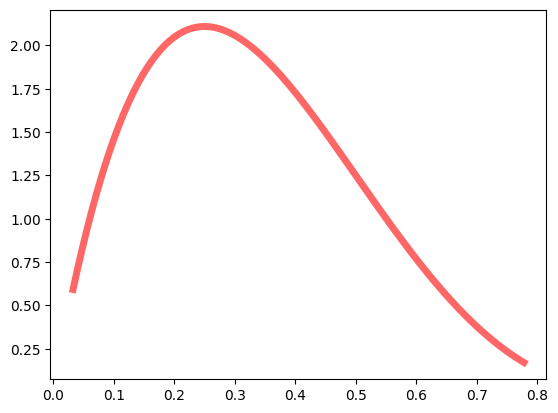

In [565]:
from scipy.stats import beta

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

a, b = 2,4
x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
plt.plot(x, beta.pdf(x, a, b), 'r-', lw=5, alpha=0.6, label='beta pdf')

In [570]:
t

array(['investment basics', 'precious metals & commodities', 'insurance'],
      dtype='<U29')

In [569]:
get_cluster_name_preferences(c)

{'tax_sebi_insurance_income_mutual': 5,
 'gold_fed_crude_inflation_rate': 3.62,
 'zomato_ondc_earth_climate_esg': 1.88,
 'multibagger_cap_fiis_cr_gdp': 1.77,
 'bitcoin_crypto_ethereum_cryptocurrency_binance': 1.51,
 'trump_pakistan_rupee_biden_imran': 1.37,
 'estate_real_housing_residential_realty': 1.3,
 'closed_yesterday_stock_reacts_monitor': 1,
 'nifty_sensex_pts_indices_sgx': 1,
 'adani_hindenburg_ports_group_enterprises': 1,
 'vaishali_buy_parekh_sell_axis': 1,
 'hindustan_dividend_vedanta_unilever_zinc': 1,
 'credit_msmes_msme_upi_suisse': 1,
 'profit_net_crore_revenue_quarter': 1,
 'ipo_gmp_ikio_mankind_subscribed': 1,
 'maruti_suzuki_hyundai_electric_hero': 1,
 'apple_5g_oneplus_iphone_galaxy': 1,
 'chatgpt_google_ai_twitter_musk': 1,
 'vande_pawar_metro_train_imd': 1,
 'covid_cases_xbb_omicron_virus': 1,
 'visa_visas_1b_immigration_eb': 1,
 'gaming_gambling_online_games_gamers': 1,
 'campaign_film_brand_whatsapp_blockchain': 1,
 'space_spacex_mission_nasa_rocket': 1,
 'appoin

In [508]:
def get_num_documents_per_cluster(cluster_preferences, total_documents, mins_since_last_call):
            
#     if mins_since_last_call is None:
#         temperature = 1/(1440 * 14)
#     else:
#         temperature = 1/mins_since_last_call
        
#     def sigmoid(a_value):
#         k = 2
#         mid_point = 3
#         return np.round((1 / (1 + np.exp(-k * (a_value - mid_point)))) * 5)/5
        
#     def get_temperature_scaled_a_value(a):
#         temperature_factor = np.log10(1/temperature)
#         temperature_multiplier = sigmoid(a)
#         return np.round((1 + temperature_factor * temperature_multiplier) * a,2)
        
    # c = deepcopy(cluster_preferences)
    # cluster_wise_prob = {cluster: get_temperature_scaled_a_value(cluster_preferences[cluster]['a']) for cluster in c.keys()}
    cluster_wise_prob = {cluster: np.round(np.random.beta(cluster_preferences[cluster]['a'],cluster_preferences[cluster]['b']),2) for cluster in c.keys()}
    days_since_call = np.clip(np.ceil(mins_since_last_call/720)/2, 0.5, 14)
    cluster_wise_proportion = {cluster: precomputed_values[cluster_wise_prob[cluster]][days_since_call] for cluster in cluster_wise_prob.keys()}
    total_sum = sum(list(cluster_wise_proportion.values()))
    if total_sum == 0:
        cluster_wise_proportion = {cluster: precomputed_values[cluster_wise_prob[cluster]][1] for cluster in cluster_wise_prob.keys()}
    cluster_wise_documents = {cluster: np.round(cluster_wise_proportion[cluster] * total_documents/total_sum) for cluster in cluster_wise_proportion.keys()}
    print(np.sum(list(cluster_wise_documents.values())))
    return cluster_wise_proportion


Characteristics of the cluster selection:

- highly uniform only in certain cases even when scrolling and not the norm - let the users who are interested in a topic, sample the articles from that cluster
- this should apply even when the number of clusters are far higher than the number of possible documents 
- the starting value of 'b' should be dependent on the number of clusters - more the number of clusters, more pessimistic i am about a random cluster

In [575]:
def get_num_documents_per_cluster(cluster_preferences, total_documents, mins_since_last_call):
    def stochastic_round(x):
        floor_val = np.floor(x)
        prob = x - floor_val
        return floor_val + (np.random.rand() < prob)
    cluster_wise_prob = {cluster: np.round(np.random.beta(cluster_preferences[cluster]['a'],cluster_preferences[cluster]['b']),2) for cluster in c.keys()}
    days_since_call = np.clip(np.ceil(mins_since_last_call/480), 10, 14)
    cluster_wise_proportion = {cluster: precomputed_values[cluster_wise_prob[cluster]][days_since_call] for cluster in cluster_wise_prob.keys()}
    total_sum = sum(list(cluster_wise_proportion.values()))
    if total_sum == 0:
        cluster_wise_proportion = {cluster: precomputed_values[cluster_wise_prob[cluster]][1] for cluster in cluster_wise_prob.keys()}
#     cluster_wise_documents_float = {cluster: (cluster_wise_proportion[cluster] * total_documents / total_sum) for cluster in cluster_wise_proportion.keys()}
    
#     print(cluster_wise_documents_float)

#     # Separate the integer and fractional parts
#     cluster_wise_documents_int = {cluster: int(np.floor(val)) for cluster, val in cluster_wise_documents_float.items()}
#     cluster_wise_documents_frac = {cluster: val - np.floor(val) for cluster, val in cluster_wise_documents_float.items()}

#     # Calculate how many documents remain to be allocated
#     remaining_documents = total_documents - sum(cluster_wise_documents_int.values())

#     # Distribute the remaining documents based on the fractional parts
#     for cluster, _ in sorted(cluster_wise_documents_frac.items(), key=lambda x: x[1], reverse=True)[:remaining_documents]:
#         cluster_wise_documents_int[cluster] += 1
    # Calculating cluster-wise documents without rounding first
    cluster_wise_documents_float = {cluster: (cluster_wise_proportion[cluster] * total_documents / total_sum) for cluster in cluster_wise_proportion.keys()}

    # Apply stochastic rounding to the calculated float values
    cluster_wise_documents = {cluster: int(stochastic_round(val)) for cluster, val in cluster_wise_documents_float.items()}
    print(cluster_wise_proportion)
    cluster_wise_documents_int = {cluster: int(np.floor(cluster_wise_proportion[cluster] * total_documents / total_sum)) for cluster in cluster_wise_proportion.keys()}

    # If the sum of the documents does not match total_documents due to stochastic rounding, you might want to adjust.
    total_allocated = sum(cluster_wise_documents.values())
    remaining_documents = total_documents - sum(cluster_wise_documents_int.values())
    if total_allocated < total_documents:
        # # Add the remaining to the clusters with highest fractional parts
        # remaining_documents = total_documents - total_allocated
        # cluster_wise_documents_frac = {cluster: val - np.floor(val) for cluster, val in cluster_wise_documents_float.items()}
        # for cluster, _ in sorted(cluster_wise_documents_frac.items(), key=lambda x: x[1], reverse=True)[:remaining_documents]:
        #     cluster_wise_documents[cluster] += 1
        total_original_proportion = sum(cluster_wise_proportion.values())
    
        # Calculate the number of extra documents each cluster should receive based on the original proportions
        extra_documents = {cluster: cluster_wise_proportion[cluster] / total_original_proportion * remaining_documents for cluster in cluster_wise_proportion.keys()}

        # Sort clusters by the extra documents they should receive, and distribute the remaining documents
        for cluster, _ in sorted(extra_documents.items(), key=lambda x: x[1], reverse=True)[:remaining_documents]:
            cluster_wise_documents_int[cluster] += 1
    # elif total_allocated > total_documents:
    #     # Remove the extra from the clusters with lowest fractional parts
    #     extra_documents = total_allocated - total_documents
    #     cluster_wise_documents_frac = {cluster: val - np.floor(val) for cluster, val in cluster_wise_documents_float.items()}
    #     for cluster, _ in sorted(cluster_wise_documents_frac.items(), key=lambda x: x[1])[:extra_documents]:
    #         cluster_wise_documents[cluster] -= 1

    return cluster_wise_documents

#### cases to handle

1. new user
    - preferences provided and some clusters have 'a' value > 1
    - preferences provided but no clusters have 'a' value > 1
    - no preferences provided (same case as above)
        - num documents > num clusters
        - num clusters > num documents

In [720]:
(np.random.rand() < 0.33)

False

In [738]:
2 + (np.random.rand() < 0.9)

3

In [739]:
list(range(-2))

[]

In [916]:
k = {'a': 1, 'b': 2}

In [919]:
for v in k:
    print(v)

a
b


In [940]:
from random import choice

In [942]:
def test_choice():
    for i in range(10):
        choice(list(range(100)))

In [943]:
%timeit test_choice()

5.33 µs ± 110 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [944]:
%timeit np.random.choice(list(range(100)), 10, replace = False)

8 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [941]:
choice([1,2,3])

2

In [957]:
np.log2(340/240)

0.5025003405291834

In [960]:
log_probs = {}

for prob in range(1, 1001):
    prob = prob/1000
    log_probs[prob] = np.log10(prob)

In [961]:
log_probs

{0.001: -3.0,
 0.002: -2.6989700043360187,
 0.003: -2.5228787452803374,
 0.004: -2.3979400086720375,
 0.005: -2.3010299956639813,
 0.006: -2.221848749616356,
 0.007: -2.154901959985743,
 0.008: -2.0969100130080562,
 0.009: -2.0457574905606752,
 0.01: -2.0,
 0.011: -1.958607314841775,
 0.012: -1.9208187539523751,
 0.013: -1.8860566476931633,
 0.014: -1.853871964321762,
 0.015: -1.8239087409443189,
 0.016: -1.7958800173440752,
 0.017: -1.7695510786217261,
 0.018: -1.744727494896694,
 0.019: -1.7212463990471711,
 0.02: -1.6989700043360187,
 0.021: -1.6777807052660807,
 0.022: -1.6575773191777938,
 0.023: -1.6382721639824072,
 0.024: -1.6197887582883939,
 0.025: -1.6020599913279623,
 0.026: -1.585026652029182,
 0.027: -1.5686362358410126,
 0.028: -1.5528419686577808,
 0.029: -1.537602002101044,
 0.03: -1.5228787452803376,
 0.031: -1.5086383061657274,
 0.032: -1.494850021680094,
 0.033: -1.4814860601221125,
 0.034: -1.4685210829577449,
 0.035: -1.4559319556497243,
 0.036: -1.443697499232712

In [958]:
np.log10(0.001)

-3.0

In [930]:
def get_num_documents_per_cluster(cluster_preferences, total_documents, mins_since_last_call):
    
    def allot_leftout_documents(left_count, alloted_dict):
        alloted_dict = deepcopy(alloted_dict)
        if left_count == 0:
            pass
        elif left_count < 0:
            selected_clusters = [cluster for cluster in alloted_dict.keys() if alloted_dict[cluster] > 0]
            selected_clusters = np.random.choice(selected_clusters, int(np.abs(left_count)), replace = False)
            alloted_dict = {cluster: alloted_dict[cluster] - 1 if cluster in selected_clusters else alloted_dict[cluster] for cluster in alloted_dict.keys()}
        elif left_count > 0:
            selected_clusters = np.random.choice(list(cluster_preferences.keys()), int(np.abs(left_count)), replace = False)
            alloted_dict = {cluster: alloted_dict[cluster] + 1 if cluster in selected_clusters else alloted_dict[cluster] for cluster in alloted_dict.keys()}
        return alloted_dict


#         # implicitly assumes that left count is less than num clusters
#         direction = -1 * (left_count/np.abs(left_count))
#         if next_cluster_preferences is None:
#             selected_clusters = np.random.choice(list(cluster_preferences.keys()), int(np.abs(left_count)), replace = False)
#         else:
#             preferred_sum = np.sum(list(next_cluster_preferences.values()))
#         alloted_dict = {cluster: alloted_dict[cluster] - direction if cluster in selected_clusters else alloted_dict[cluster] for cluster in alloted_dict.keys()}
#         return alloted_dict
    
    num_clusters = len(cluster_preferences)
    
    if mins_since_last_call is None:
        # If this is the very first call, then make it determisitic number of articles - and based on proportion of 'a' values
        if max([x['a'] for x in cluster_preferences.values()]) > 1:
            c = {cluster: cluster_preferences[cluster]['a'] - 1 for cluster in cluster_preferences.keys()}
            sorted_c = {k: v for k, v in sorted(c.items(), key=lambda item: item[1], reverse=True)}
            total_sum = np.sum(list(c.values()))
            num_docs = {cluster: np.round(c[cluster] * total_documents/total_sum) for cluster in c.keys()}
            # ignored_clusters = {cluster: c[cluster] if num_docs[cluster] == 0 for cluster in c.keys()}
            left_count = total_documents - np.sum(list(num_docs.values()))
            print(left_count)
            num_docs = allot_leftout_documents(left_count, num_docs)
            return {k: v for k, v in sorted(num_docs.items(), key=lambda item: item[1], reverse=True)}
        else:
            # The default value ideally should be based on the most popular clusters, but at immediate launch this won't be availalbe
            # Hence we'll use ratio of cluster sizes - which is definitely incorrect but more doesn't mean relevant - but its for only the v0
            # For now, we'll samply take uniform sampling
            num_samples = min(num_clusters, total_documents)
            
            if num_clusters <= total_documents:

                print(docs_left_to_allot)
                if docs_left_to_allot == 0:
                    return num_docs
                elif docs_left_to_allot < 0:
                    selected_clusters = np.random.choice(list(cluster_preferences.keys()), -1 * docs_left_to_allot, replace = False)
                    num_docs = {cluster: num_docs[cluster] - 1 if cluster in selected_clusters else num_docs[cluster] for cluster in num_docs.keys()}
                elif docs_left_to_allot > 0:
                    selected_clusters = np.random.choice(list(cluster_preferences.keys()), docs_left_to_allot, replace = False)
                    num_docs = {cluster: num_docs[cluster] + 1 if cluster in selected_clusters else num_docs[cluster] for cluster in num_docs.keys()}
                
                return num_docs                        
            else:
                selected_clusters = np.random.choice(list(cluster_preferences.keys()), num_samples, replace = False)
                num_docs = {cluster: 1 for cluster in selected_clusters}
            return num_docs
            
            
    
    cluster_wise_prob = {cluster: np.round(np.random.beta(cluster_preferences[cluster]['a'],cluster_preferences[cluster]['b']),2) for cluster in c.keys()}
    print(cluster_wise_prob)
    num_clusters = len(cluster_preferences)
    num_consideration_clusters = min(10, total_documents, num_clusters)
    epsilon = 1e-3
    prob_cutoff = sorted(list(cluster_wise_prob.values()))[::-1][num_consideration_clusters-1] - epsilon
    cluster_wise_prob = {cluster: cluster_wise_prob[cluster] if cluster_wise_prob[cluster] > prob_cutoff else 0 for cluster in cluster_wise_prob.keys()}
    
    if mins_since_last_call is None:
        hour_blocks_since_last_call = 15
    elif mins_since_last_call <= 1440:
        hour_blocks_since_last_call = np.ceil(mins_since_last_call/480)
    else:
        hour_blocks_since_last_call = max(3, np.clip(np.ceil(mins_since_last_call/1440), 1, 5))
    cluster_wise_proportion = {cluster: precomputed_values[cluster_wise_prob[cluster]][hour_blocks_since_last_call] for cluster in cluster_wise_prob.keys()}
    total_sum = sum(list(cluster_wise_proportion.values()))
    print(cluster_wise_prob)
    print(cluster_wise_proportion)
    print(total_sum)
    if total_sum == 0:
        cluster_wise_proportion = {cluster: precomputed_values[cluster_wise_prob[cluster]][1] for cluster in cluster_wise_prob.keys()}
    cluster_wise_documents_float = {cluster: int(cluster_wise_proportion[cluster] * total_documents / total_sum) for cluster in cluster_wise_proportion.keys()}
    sorted_doc_count = {k: v for k, v in sorted(cluster_wise_documents_float.items(), key=lambda item: item[1], reverse=True)}
    return sorted_doc_count
    
#     days_since_call = np.clip(np.ceil(mins_since_last_call/480), 1, 14)
#     cluster_wise_proportion = {cluster: precomputed_values[cluster_wise_prob[cluster]][days_since_call] for cluster in cluster_wise_prob.keys()}

#     cluster_wise_proportion = {}
#     total_sum = sum(list(cluster_wise_proportion.values()))
#     # if total_sum == 0:
#     #     cluster_wise_proportion = {cluster: precomputed_values[cluster_wise_prob[cluster]][1] for cluster in cluster_wise_prob.keys()}
#     cluster_wise_documents_float = {cluster: int(cluster_wise_proportion[cluster] * total_documents / total_sum) for cluster in cluster_wise_proportion.keys()}
    

# #     # Apply stochastic rounding to the calculated float values
# #     cluster_wise_documents = {cluster: int(stochastic_round(val)) for cluster, val in cluster_wise_documents_float.items()}
# #     print(cluster_wise_proportion)
# #     cluster_wise_documents_int = {cluster: int(np.floor(cluster_wise_proportion[cluster] * total_documents / total_sum)) for cluster in cluster_wise_proportion.keys()}

# #     # If the sum of the documents does not match total_documents due to stochastic rounding, you might want to adjust.
# #     total_allocated = sum(cluster_wise_documents.values())
# #     remaining_documents = total_documents - sum(cluster_wise_documents_int.values())
# #     if total_allocated < total_documents:
# #         # # Add the remaining to the clusters with highest fractional parts
# #         # remaining_documents = total_documents - total_allocated
# #         # cluster_wise_documents_frac = {cluster: val - np.floor(val) for cluster, val in cluster_wise_documents_float.items()}
# #         # for cluster, _ in sorted(cluster_wise_documents_frac.items(), key=lambda x: x[1], reverse=True)[:remaining_documents]:
# #         #     cluster_wise_documents[cluster] += 1
# #         total_original_proportion = sum(cluster_wise_proportion.values())
    
# #         # Calculate the number of extra documents each cluster should receive based on the original proportions
# #         extra_documents = {cluster: cluster_wise_proportion[cluster] / total_original_proportion * remaining_documents for cluster in cluster_wise_proportion.keys()}

# #         # Sort clusters by the extra documents they should receive, and distribute the remaining documents
# #         for cluster, _ in sorted(extra_documents.items(), key=lambda x: x[1], reverse=True)[:remaining_documents]:
# #             cluster_wise_documents_int[cluster] += 1
# #     # elif total_allocated > total_documents:
# #     #     # Remove the extra from the clusters with lowest fractional parts
# #     #     extra_documents = total_allocated - total_documents
# #     #     cluster_wise_documents_frac = {cluster: val - np.floor(val) for cluster, val in cluster_wise_documents_float.items()}
# #     #     for cluster, _ in sorted(cluster_wise_documents_frac.items(), key=lambda x: x[1])[:extra_documents]:
# #     #         cluster_wise_documents[cluster] -= 1

#     return cluster_wise_documents_float

In [937]:
j = get_num_documents_per_cluster(c,total_documents=50,mins_since_last_call=None)

0.0


In [938]:
j

{'1920': 14.0,
 '1800': 13.0,
 '1870': 8.0,
 '1815': 6.0,
 '1873': 2.0,
 '1904': 2.0,
 '1822': 2.0,
 '1652': 2.0,
 '1785': 1.0,
 '1927': 0.0,
 '1862': 0.0,
 '1781': 0.0,
 '1891': 0.0,
 '1826': 0.0,
 '1732': 0.0,
 '1414': 0.0,
 '1905': 0.0,
 '1902': 0.0,
 '1882': 0.0,
 '1899': 0.0,
 '1555': 0.0,
 '1304': 0.0,
 '1637': 0.0,
 '1844': 0.0,
 '1290': 0.0,
 '1568': 0.0,
 '1547': 0.0,
 '1790': 0.0,
 '1887': 0.0,
 '1823': 0.0,
 '1879': 0.0,
 '1774': 0.0,
 '1236': 0.0,
 '1784': 0.0}

In [914]:
list(j.values())

[6.0,
 5.0,
 3.0,
 3.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0]

In [913]:
sum()

20.0

In [911]:
sum(list(j.values()))

20.0

In [890]:
c

{'1927': {'a': 1, 'b': 4.0},
 '1862': {'a': 1, 'b': 4.0},
 '1781': {'a': 1, 'b': 4.0},
 '1891': {'a': 1, 'b': 4.0},
 '1826': {'a': 1, 'b': 4.0},
 '1873': {'a': 1.43, 'b': 4.0},
 '1870': {'a': 3.2, 'b': 4.0},
 '1732': {'a': 1, 'b': 4.0},
 '1904': {'a': 1.59, 'b': 4.0},
 '1414': {'a': 1, 'b': 4.0},
 '1815': {'a': 2.78, 'b': 4.0},
 '1905': {'a': 1, 'b': 4.0},
 '1902': {'a': 1, 'b': 4.0},
 '1882': {'a': 1, 'b': 4.0},
 '1899': {'a': 1, 'b': 4.0},
 '1555': {'a': 1, 'b': 4.0},
 '1304': {'a': 1, 'b': 4.0},
 '1637': {'a': 1, 'b': 4.0},
 '1844': {'a': 1, 'b': 4.0},
 '1290': {'a': 1, 'b': 4.0},
 '1800': {'a': 4.51, 'b': 4.0},
 '1785': {'a': 1.39, 'b': 4.0},
 '1568': {'a': 1, 'b': 4.0},
 '1547': {'a': 1, 'b': 4.0},
 '1822': {'a': 1.51, 'b': 4.0},
 '1790': {'a': 1, 'b': 4.0},
 '1887': {'a': 1, 'b': 4.0},
 '1823': {'a': 1, 'b': 4.0},
 '1879': {'a': 1, 'b': 4.0},
 '1774': {'a': 1, 'b': 4.0},
 '1652': {'a': 1.51, 'b': 4.0},
 '1920': {'a': 5, 'b': 4.0},
 '1236': {'a': 1, 'b': 4.0},
 '1784': {'a': 1, 'b

In [891]:
j

{'1920': 6.0,
 '1800': 5.0,
 '1870': 3.0,
 '1815': 3.0,
 '1873': 1.0,
 '1904': 1.0,
 '1785': 1.0,
 '1822': 1.0,
 '1652': 1.0,
 '1927': 0.0,
 '1862': 0.0,
 '1781': 0.0,
 '1891': 0.0,
 '1826': 0.0,
 '1732': 0.0,
 '1414': 0.0,
 '1905': 0.0,
 '1902': 0.0,
 '1882': 0.0,
 '1899': 0.0,
 '1555': 0.0,
 '1304': 0.0,
 '1637': 0.0,
 '1844': 0.0,
 '1290': 0.0,
 '1568': 0.0,
 '1547': 0.0,
 '1790': 0.0,
 '1887': 0.0,
 '1823': 0.0,
 '1879': 0.0,
 '1774': 0.0,
 '1236': 0.0,
 '1784': 0.0}

In [871]:
c

{'1927': {'a': 1, 'b': 4.0},
 '1862': {'a': 1, 'b': 4.0},
 '1781': {'a': 1, 'b': 4.0},
 '1891': {'a': 1, 'b': 4.0},
 '1826': {'a': 1, 'b': 4.0},
 '1873': {'a': 1, 'b': 4.0},
 '1870': {'a': 1.77, 'b': 4.0},
 '1732': {'a': 1.3, 'b': 4.0},
 '1904': {'a': 3.62, 'b': 4.0},
 '1414': {'a': 1, 'b': 4.0},
 '1815': {'a': 1, 'b': 4.0},
 '1905': {'a': 1, 'b': 4.0},
 '1902': {'a': 1, 'b': 4.0},
 '1882': {'a': 1, 'b': 4.0},
 '1899': {'a': 1, 'b': 4.0},
 '1555': {'a': 1, 'b': 4.0},
 '1304': {'a': 1, 'b': 4.0},
 '1637': {'a': 1, 'b': 4.0},
 '1844': {'a': 1, 'b': 4.0},
 '1290': {'a': 1, 'b': 4.0},
 '1800': {'a': 1, 'b': 4.0},
 '1785': {'a': 1.88, 'b': 4.0},
 '1568': {'a': 1, 'b': 4.0},
 '1547': {'a': 1, 'b': 4.0},
 '1822': {'a': 1, 'b': 4.0},
 '1790': {'a': 1, 'b': 4.0},
 '1887': {'a': 1.37, 'b': 4.0},
 '1823': {'a': 1.51, 'b': 4.0},
 '1879': {'a': 1, 'b': 4.0},
 '1774': {'a': 1, 'b': 4.0},
 '1652': {'a': 1, 'b': 4.0},
 '1920': {'a': 5, 'b': 4.0},
 '1236': {'a': 1, 'b': 4.0},
 '1784': {'a': 1, 'b': 4.0

In [865]:
j

{'1920': 4,
 '1904': 2,
 '1927': 0,
 '1862': 0,
 '1781': 0,
 '1891': 0,
 '1826': 0,
 '1873': 0,
 '1870': 0,
 '1732': 0,
 '1414': 0,
 '1815': 0,
 '1905': 0,
 '1902': 0,
 '1882': 0,
 '1899': 0,
 '1555': 0,
 '1304': 0,
 '1637': 0,
 '1844': 0,
 '1290': 0,
 '1800': 0,
 '1785': 0,
 '1568': 0,
 '1547': 0,
 '1822': 0,
 '1790': 0,
 '1887': 0,
 '1823': 0,
 '1879': 0,
 '1774': 0,
 '1652': 0,
 '1236': 0,
 '1784': 0}

In [140]:
c1 = get_num_documents_per_cluster(c)

In [425]:
k = 2


0.9933071490757153

In [222]:
import numpy as np

def map_power(time_since_last_visit_minutes):
#     # Set time bounds: 10 minutes and 2 weeks (in minutes)
    lower_bound = 10.0
    upper_bound = 14 * 24 * 60.0  # 2 weeks in minutes

#     # Clamp the input time to be within the bounds
    clamped_time = np.clip(time_since_last_visit_minutes, lower_bound, upper_bound)

#     # Map time to a logarithmic scale between 0 and 1
#     log_scaled_time = np.log(clamped_time / lower_bound) / np.log(upper_bound / lower_bound)

#     # Map the scaled time to a value between 0.5 and 10
#     power_value = 0.5 + 9.5 * log_scaled_time

#     return power_value
    # Time for the center of the curve: 4 days (in minutes)
#     t_0 = 4 * 24 * 60.0
    
#     # Constant to control the steepness of the curve
#     k = 0.001
    
#     # Compute the sigmoid function
#     sigmoid_value = 1 / (1 + np.exp(-k * (clamped_time - t_0)))
    
#     # Stretch and shift to fit the range [0.5, 10]
#     power_value = 0.5 + 9.5 * sigmoid_value
    # power_value = np.floor(power_value * 2) / 2
    
    
    # Desired outputs at 10 minutes and 2 weeks

    # Calculate sigmoid value
    k = 0.0001
    sigmoid_value = 1 / (1 + np.exp(-k * (clamped_time - upper_bound / 2)))

    # Scale and translate sigmoid
    # min_sigmoid = 1 / (1 + np.exp(-k * (lower_bound - upper_bound / 2)))
    # max_sigmoid = 1 / (1 + np.exp(-k * (upper_bound - upper_bound / 2)))
    power_value = 0.5 + 9.5 * sigmoid_value

    # scaled_value = lower_bound + (upper_bound - lower_bound) * (sigmoid_value - min_sigmoid) / (max_sigmoid - min_sigmoid)

    # Round to nearest 0.5
    # rounded_value = round(scaled_value * 2) / 2
    return power_value

In [375]:
def map_power2(time_since_last_visit_minutes):
    # Constants
    A = 0.5
    B = 9.5
    k = 0.0005
    x_0 = 4 * 24 * 60  # 4 days in minutes
    
    # Compute the sigmoid function
    sigmoid_value = 1 / (1 + np.exp(-k * (time_since_last_visit_minutes - x_0)))
    
    # Stretch and shift to fit the range [0.5, 10]
    power_value = A + B * sigmoid_value
    
    # Round to the nearest 0.5
    power_value = round(power_value * 2) / 2 - 0.5
    
    return power_value

In [343]:
np.log10(60 * 1440/(1 * 12 * 6 * 10))

2.0791812460476247

In [276]:
np.tanh(2)

0.9640275800758169

In [236]:
%timeit 1 / (1 + np.exp(-0.0001 * (30 - 4)))

352 ns ± 3.06 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [ ]:
np.log()

In [389]:
map_power2(time_since_last_visit_minutes=20 * 1440)

9.5

In [394]:
lst = [precomputed_values[x][9.5] for x in c1.values()]

In [395]:
lst/sum(lst)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02826855, 0.26501767, 0.        , 0.1590106 , 0.        ,
       0.        , 0.01413428, 0.        , 0.        , 0.        ,
       0.00353357, 0.00353357, 0.        , 0.        , 0.        ,
       0.24028269, 0.03886926, 0.        , 0.        , 0.03180212,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.2155477 , 0.        , 0.        ])

In [353]:
c

{'1927': {'a': 1, 'b': 2},
 '1862': {'a': 1, 'b': 2},
 '1781': {'a': 1, 'b': 2},
 '1891': {'a': 1, 'b': 2},
 '1826': {'a': 1, 'b': 2},
 '1873': {'a': 1.35, 'b': 1},
 '1870': {'a': 2.64, 'b': 1},
 '1732': {'a': 1, 'b': 2},
 '1904': {'a': 5, 'b': 1},
 '1414': {'a': 1, 'b': 2},
 '1815': {'a': 1, 'b': 2},
 '1905': {'a': 1, 'b': 2},
 '1902': {'a': 1, 'b': 2},
 '1882': {'a': 1, 'b': 2},
 '1899': {'a': 1, 'b': 2},
 '1555': {'a': 1, 'b': 2},
 '1304': {'a': 1, 'b': 2},
 '1637': {'a': 1, 'b': 2},
 '1844': {'a': 1, 'b': 2},
 '1290': {'a': 1, 'b': 2},
 '1800': {'a': 4.52, 'b': 1},
 '1785': {'a': 2.51, 'b': 1},
 '1568': {'a': 1, 'b': 2},
 '1547': {'a': 1, 'b': 2},
 '1822': {'a': 1.51, 'b': 1},
 '1790': {'a': 1, 'b': 2},
 '1887': {'a': 1.44, 'b': 1},
 '1823': {'a': 1.4, 'b': 1},
 '1879': {'a': 1, 'b': 2},
 '1774': {'a': 1, 'b': 2},
 '1652': {'a': 1, 'b': 2},
 '1920': {'a': 5, 'b': 1},
 '1236': {'a': 1, 'b': 2},
 '1784': {'a': 1, 'b': 2}}

In [141]:
c1

{'1927': 0.27,
 '1862': 0.13,
 '1781': 0.29,
 '1891': 0.14,
 '1826': 0.0,
 '1873': 0.77,
 '1870': 0.97,
 '1732': 0.28,
 '1904': 0.92,
 '1414': 0.17,
 '1815': 0.28,
 '1905': 0.71,
 '1902': 0.17,
 '1882': 0.42,
 '1899': 0.12,
 '1555': 0.58,
 '1304': 0.64,
 '1637': 0.23,
 '1844': 0.46,
 '1290': 0.37,
 '1800': 0.96,
 '1785': 0.79,
 '1568': 0.15,
 '1547': 0.05,
 '1822': 0.78,
 '1790': 0.46,
 '1887': 0.41,
 '1823': 0.4,
 '1879': 0.19,
 '1774': 0.52,
 '1652': 0.24,
 '1920': 0.95,
 '1236': 0.56,
 '1784': 0.51}

In [127]:
np.round(0.008,2)

0.01

In [635]:
def precompute_powers():
    # Initialize an empty dictionary to store the precomputed values
    precomputed = {}

    # Iterate over all 2-decimal values between 0 and 1
    for i in range(101):  # 0.00, 0.01, ..., 1.00
        value = i / 100.0

        # Create a sub-dictionary for each value to store the corresponding powers
        precomputed[value] = {}

        # Compute and store the powers from 0.5 to 10 in increments of 0.5
        for power in [x * 0.5 for x in range(1, 41)]:  # 0.5, 1.0, ..., 10.0
            precomputed[value][power] = np.round(value**power,3)

    return precomputed

# Generate the precomputed values and store them in a dictionary
precomputed_values = precompute_powers()

In [110]:
c1

{'1927': 0.3058143512286309,
 '1862': 0.134290236487873,
 '1781': 0.4791097821525532,
 '1891': 0.5415526868450048,
 '1826': 0.27350935209576965,
 '1873': 0.2432452114226264,
 '1870': 0.5440971372236233,
 '1732': 0.04096939551870805,
 '1904': 0.7220735427617851,
 '1414': 0.2647644598777726,
 '1815': 0.6339427261833347,
 '1905': 0.31586527518761276,
 '1902': 0.7317563843399155,
 '1882': 0.1685360006409122,
 '1899': 0.12862619208187787,
 '1555': 0.4522897803591004,
 '1304': 0.32447579650636377,
 '1637': 0.4933986781051965,
 '1844': 0.7501346764449568,
 '1290': 0.05197096375792963,
 '1800': 0.4991126880201249,
 '1785': 0.44621732964171834,
 '1568': 0.1711284792134007,
 '1547': 0.7096408571549939,
 '1822': 0.124995576597128,
 '1790': 0.4116100648548768,
 '1887': 0.18252134348259055,
 '1823': 0.8363948422696686,
 '1879': 0.7192594040192023,
 '1774': 0.4394159282263022,
 '1652': 0.06934897105054899,
 '1920': 0.9039934095612591,
 '1236': 0.39961423385395595,
 '1784': 0.21933368664376704}

In [120]:
def log_transform(values, base=np.e):
    # Add a small constant to avoid log(0)
    epsilon = 1e-9
    log_values = np.log(values + epsilon) / np.log(base)
    
    # Shift by the minimum log value to make all values positive
    log_values -= np.min(log_values)
    
    # Exponentiate and normalize
    exp_values = np.exp(log_values)
    return exp_values / np.sum(exp_values)

In [122]:
keys = list(c1.keys())
values = np.array(list(c1.values()))

# Apply the log transform
transformed_values = log_transform(values)

# Create a new dictionary with the transformed values
transformed_dict = dict(zip(keys, transformed_values))

In [123]:
transformed_dict

{'1927': 0.022268560487251253,
 '1862': 0.009778645948278894,
 '1781': 0.034887457401574506,
 '1891': 0.039434378074231356,
 '1826': 0.019916199252442705,
 '1873': 0.017712447720628636,
 '1870': 0.03961965795645452,
 '1732': 0.0029832788351965944,
 '1904': 0.052579410574824494,
 '1414': 0.019279420239646818,
 '1815': 0.04616196677120326,
 '1905': 0.023000441141322138,
 '1902': 0.05328448848173014,
 '1882': 0.012272328356957874,
 '1899': 0.009366205804321613,
 '1555': 0.032934498595510425,
 '1304': 0.023627435634602238,
 '1637': 0.03592793552661552,
 '1844': 0.05462274519339526,
 '1290': 0.0037843827925627656,
 '1800': 0.03634401402158493,
 '1785': 0.03249231942661132,
 '1568': 0.012461105520235688,
 '1547': 0.051674096584698785,
 '1822': 0.009101834364790024,
 '1790': 0.029972313535494892,
 '1887': 0.01329070257888461,
 '1823': 0.06090397335129359,
 '1879': 0.05237449272727405,
 '1774': 0.03199706007166764,
 '1652': 0.005049801513834141,
 '1920': 0.06582631520220485,
 '1236': 0.0290988

In [121]:
log_transform(c1)

TypeError: unsupported operand type(s) for +: 'dict' and 'float'

In [111]:
def softmax(x):
    e_x = np.exp(x - np.max(x))  # subtract np.max(x) for numerical stability
    return e_x / e_x.sum()

# Your dictionary of probabilities

# Extract the keys and values
keys = list(c1.keys())
values = np.array(list(c1.values()))

# Compute softmax values
softmax_values = softmax(values)

# Create a new dictionary with the softmax values
softmax_dict = dict(zip(keys, softmax_values))

print(softmax_dict)

{'1927': 0.025894158675536617, '1862': 0.02181272019399005, '1781': 0.030793783661271598, '1891': 0.03277794055651506, '1826': 0.02507101531050318, '1873': 0.0243236291212266, '1870': 0.032861448595751276, '1732': 0.019869232977808793, '1904': 0.03926276447993238, '1414': 0.024852727825175287, '1815': 0.03595060038056499, '1905': 0.02615573121619972, '1902': 0.03964478615119625, '1882': 0.022572651410486977, '1899': 0.021689521209820435, '1555': 0.029978871153190145, '1304': 0.026381918093432034, '1637': 0.03123695148123062, '1844': 0.04038012605999493, '1290': 0.02008903255334988, '1800': 0.03141595064618288, '1785': 0.029797377548743117, '1568': 0.022631246445962046, '1547': 0.03877764479217697, '1822': 0.02161091767420786, '1790': 0.028783811348092676, '1887': 0.022890555496575815, '1823': 0.04401796739915532, '1879': 0.03915242893584887, '1774': 0.02959540126240947, '1652': 0.02044119095069659, '1920': 0.04709639542497578, '1236': 0.028440588349944087, '1784': 0.023748912617851684}

In [113]:
np.sum(list(softmax_dict.values()))

1.0

In [235]:
n_items = 21

In [246]:
max_clusters = int(n_items/3)

In [247]:
num_clusters = len(c1)

In [248]:
num_clusters

34

In [249]:
num_clusters-max_clusters

27

In [273]:
topics

array(['automobile sector', 'IPOs, M&As', 'global economy', 'oil & gas'],
      dtype='<U29')

In [251]:
prob_cutoff = sorted(c1.values())[num_clusters-max_clusters]

In [269]:
updated_c1 = {clu: c1[clu]**10 if c1[clu] >= prob_cutoff - 0.0001 else 0 for clu in c1.keys()}
total_sum = np.sum(list(updated_c1.values()))
scaled_c1 = {clu: np.round(updated_c1[clu]*n_items/total_sum) for clu in updated_c1.keys()}

In [270]:
np.sum(list(scaled_c1.values()))

21.0

In [277]:
cluster_wise_num_documents = {k: v for k, v in sorted(scaled_c1.items(), key=lambda item: item[1], reverse=True)}

In [280]:
document_list = []
for cluster, num in cluster_wise_num_documents.items():
    if num == 0:
        break
    else:
        document_list.extend(np.random.choice(cluster_to_documents[cluster],int(num)))

In [283]:
topics

array(['automobile sector', 'IPOs, M&As', 'global economy', 'oil & gas'],
      dtype='<U29')

In [286]:
document_list[8]

18595

In [289]:
ect_bge_small.bertopic_model.topics_[18595]

663

In [290]:
ect_bge_small.bertopic_model.topic_labels_[663]

'663_codes_redeem_updating_microsite'

In [291]:
topic_cluster_map[663]

'1784'

In [293]:
balanced_clusters_df[balanced_clusters_df.Parent_ID == '1784']

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance,Level,num_points,points
816,1784,codes_redeem_garena_max_fire,"[298, 425, 586, 589, 600, 640, 663, 671, 851, ...",1243,codes_redeem_garena_max_fire,1020,bgmi_redeem_codes_unlock_exciting,1.207107,2,209,"[12874, 15409, 15438, 15795, 15807, 15864, 158..."


In [282]:
[ect_bge_small.documents[x] for x in document_list]

["EXCLUSIVE INTERVIEW | From fitness to acting: A day in the life of Bollywood actor Soha Ali Khan Fitness Tips: Soha Ali Khan's Fitness Routine Will Inspire You ",
 'Uttar Pradesh Budget : ‘Focus is on infrastructure, goal is to achieve  trillion economy,’ says FM Suresh Khanna Previously, on  May , the state government presented an annual budget of  lakh crore rupees. ',
 '75% of Indian families discuss finances together: Survey According to their recently-concluded survey, 64% of conversations on financial matters for people aged + dwell on monthly budgeting and expenses, whereas new investments and big purchases account for 60% and 54%, respectively.',
 'Digital public infrastructure: Sowing future growth Without public funding, DPI will end up benefiting only large players; in a PPP mode, it can harness private-sector innovation and public-sector inclusivity',
 "Nomura hires top ICICI banker to head India ECM business: Report Mahesh Natarajan replaces Mangesh Ghogre, who headed No

### Issues observed

- There are documents which are irrelevant to user like Garena codes (topic 663 and cluster 1784). 
- The user's prior for that cluster is 1,2 - so it happened out of pure chance
    - potential actionable: further suppress non direct cluster preferences
- all those documents are actually shit and irrelevant
    - potential actionable: the llm should be used to filter out documents which are classified as irrelevant for users

In [229]:
np.sum(list(c1.values()))

112.17806864638919

In [ ]:
def get_documents_in_cluster(generate_feed_proprotion, n_items = 20):
    
    